# AaronTools and Psi4

You can download the Jupyter Notebook version of this page <a href="https://github.com/QChASM/AaronTools-docs/blob/main/source/tutorials/Jupyter_Psi4.ipynb" target="_blank">here</a> (click "Download raw file").

Psi4 is an open-source quantum chemistry package that has a simple Python API that lets you run quantum chemistry computations straight from Jupyter.
By combining this with the molecular building, visualization, and analysis tools from AaronTools, you can do quite a lot right from a Jupyter Notebook.

For example, below we first build formadlehyde using AaronTools:

In [1]:
from AaronTools.geometry import Geometry
import numpy as np

geom = Geometry.from_string('formaldehyde', form='iupac')
geom.display()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

We can print the C-O bond length and H-C-O angle (remember, hovering over atoms in the above structure will give you atom numbers).
Note that `geom.angle()` will return the angle in radians, so we convert this to degrees using Numpy.

In [2]:
atom1 = geom.atoms[0]
d = atom1.dist(geom.atoms[1])
a = np.degrees(geom.angle('3', '1', '2'))
print(f"C-O bond distance: {d:.3f} Angstroms")
print(f"HCO angle:         {a:.1f} degrees")

C-O bond distance: 1.223 Angstroms
HCO angle:         133.7 degrees


To run Psi4 computations on this molecule, we need to convert the AaronTools `Geometry` into a Psi4 `Molecule`.
We can then run a HF/STO-3G geometry optimization using `psi4.opt('scf')`.
Note that the native geometry optimizer in Psi4 (OptKing) will print all sorts of messages/warnings to the screen.  Just ignore those.
Once finished, it should say `Optimization complete`

In [3]:
import psi4
mol = geom.convert_to_Psi4()

# set psi4 parameters 
psi4.set_memory('2 GB')
psi4.set_options({'basis': 'sto-3g'})

# Perform HF/sto-3g geometry optimization
psi4.core.set_output_file('formaldehyde_optimization.dat')
energy = psi4.opt('scf')

	Energy has increased in a minimization.
	Energy ratio indicates iffy step.
	Intrafrag trust radius decreased to   0.25.
	Energy has increased in a minimization.
	Energy ratio indicates iffy step.
	Intrafrag trust radius decreased to 0.0625.


Optimizer: Optimization complete!


To view this optimized structure, we can create a `Geometry` object from the saved output file.
If the output filename ends with '.dat' or '.out' then AaronTools will automatically parse it as a Psi4 output.
If you use some other ending you'll have to give AaronTools more information to know how to parse the file.

In [4]:
opt_geom = Geometry('formaldehyde_optimization.dat')
opt_geom.display()

atom1 = opt_geom.atoms[0]
dnew = atom1.dist(opt_geom.atoms[1])
anew = np.degrees(opt_geom.angle('3', '1', '2'))
print("After Optimization")
print(f"C-O bond distance: {dnew:.3f} Angstroms")
print(f"HCO angle:         {anew:.1f} degrees")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

After Optimization
C-O bond distance: 1.217 Angstroms
HCO angle:         122.7 degrees


Of course, visually this looks pretty much like our starting structure, but if we print the C-O bond length and HCO angle we see that the structure has indeed changed (this level of theory gives a pretty terrible structure for formaldehyde, but the idea here is to make this example run as quickly as possible).

Suppose we now want to compute vibrational frequencies, which must be run on the optimized geometry (at the same level of theory).

Our Psi4 molecule `mol` will contain the optimized structure (or we could recreate it from `opt_geom` using `opt_geom.convert_to_Psi4()` to be safe), so we simply ask Psi4 to run frequencies and save the results to a new output file.

In [5]:
# perform HF/sto-3g frequency computation
psi4.core.set_output_file('formaldehyde_freq.dat')
energy = psi4.freq('scf')

A  limitation of the Psi4 API is that some of the data you likely need is found in the saved output file but not available through the API.

However, we can just use AaronTools to parse the output file using a `FileReader` object!

For instance, below we create a `FileReader` object (remembering to set `just_geom=False`) and then save the `Frequency` object.
We can list the values of all real and imaginary frequencies or print a table of frequencies with IR intensities.

We also plot a simulated IR spectrum using `freq.plot_ir()`.

Real frequencies
[1278.704, 1397.6315, 1767.1892, 2099.6902, 3498.6582, 3645.6594]

Imaginary frequencies
[]

  Freq     Intensity
 (cm-1)     (km/mol)
--------------------
 1278.7       6.16
 1397.6      29.60
 1767.2       4.15
 2099.7       8.47
 3498.7       1.82
 3645.7      19.93


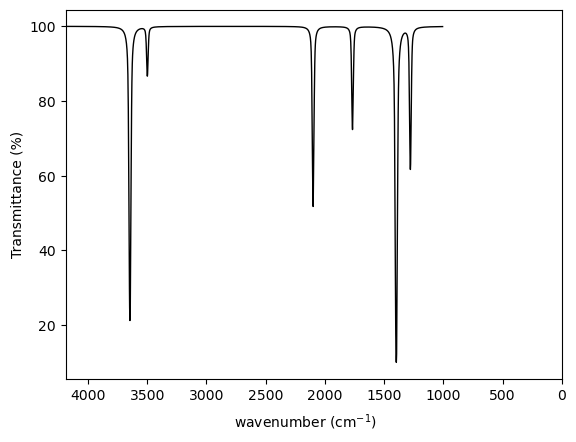

In [6]:
from AaronTools.fileIO import FileReader
import matplotlib.pyplot as plt

# create FileReader
fr = FileReader('formaldehyde_freq.dat', just_geom=False)

# grab Frequency object from FileReader
freq = fr.other["frequency"]

# print frequency values
print("Real frequencies")
print(freq.real_frequencies)

# print imaginary values
print("\nImaginary frequencies")
print(freq.imaginary_frequencies)

# loop over frequency values and print intensities
print("\n  Freq     Intensity")
print(" (cm-1)     (km/mol)")
print("-"*20)
for frq, dict in freq.by_frequency.items():
    print(f" {frq:6.1f}     {dict['intensity']:6.2f}")
    
# create MatpLotlib figure and plot IR spectrum
fig = plt.gcf()
freq.plot_ir(fig)

Finally, suppose we want to calculate some thermodynamic quantities (e.g. absolute free energy, etc.) at T=100K.
By default, Psi4 computed these quantities at 298.15K. However, we can use AaronTools to recompute these values at any desired temperature.
We do this using using a `CompOutput` object in AaronTools, which can be created by reading any QM output file containing frequencies.

In [7]:
from AaronTools.comp_output import CompOutput

# create CompOutput object 
co = CompOutput('water_freq.dat')

# Electronic energy
E = co.energy

# correction to E to get RRHO G
dG = co.calc_G_corr(temperature=100)
print(f"RRHO Free energy G(100K):  {E + dG} hartrees")

# Grimme's quasi-RRHO free energy
QRRHO_G = co.calc_Grimme_G(temperature=100)
print(f"QRRHO Free energy G(100K): {QRRHO_G} hartrees")

RRHO Free energy G(100K):  -150.88731175953797 hartrees
QRRHO Free energy G(100K): -150.88732341443506 hartrees


Notice that while Psi4 is limited to the standard RRHO free energy, AaronTools allows us to evaluate G using the RRHO, quasi-RRHO, and quasi-harmonic approximations.
For formaldehyde, these three approximations will be essentially equivalent, because there are no low-frequency vibrational modes for formaldehyde (< 100 cm-1).

Also, keep in mind that these thermochemical quantitites will be **absolute free energies**, not free energies of formation.